# Generating Specific Handwritten Digit Using CGAN

We just learned how CGAN works and the architecture of CGAN. To strengthen our understanding, now we will learn how to implement CGAN in TensorFlow for generating an image of specific handwritten digit. 

## Import libraries

First, we will import all the necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

### Read the Dataset

Load the MNIST dataset:

In [2]:
data = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


## Defining Generator 

Generator $G$ takes the noise $z$ and also the conditional variable $c$ as an input and returns an image. We define the generator as a simple 2 layer feed forward network. 

In [3]:
def generator(z, c,reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        
        #initialize weights
        w_init = tf.contrib.layers.xavier_initializer()
        
        #concatenate noize z and conditional  variable c to form an input
        inputs = tf.concat([z, c], 1)
        
        #define the first layer with relu activation
        dense1 = tf.layers.dense(inputs, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)
        
        #define the second layer and compute the output using the tanh activation function
        logits = tf.layers.dense(relu1, 784, kernel_initializer=w_init)
        output = tf.nn.tanh(logits)

        return output

## Defining Discriminator

We know that discriminator $D$ returns the probability. i.e it will tell us the probability of the given image being real. Along with the input image $x$, it also takes the conditional varaible $c$ as an input. We define the discriminator also as a simple 2 layer feed forward network. 

In [1]:
def discriminator(x, c, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #initialize weights
        w_init = tf.contrib.layers.xavier_initializer()
        
        #concatenate noize z and conditional variable c to form an input
        inputs = tf.concat([x, c], 1)
    
        #define the first layer with the relu activation
        dense1 = tf.layers.dense(inputs, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)
        
        #define the second layer and compute the output using sigmoid activation function
        logits = tf.layers.dense(relu1, 1, kernel_initializer=w_init)
        output = tf.nn.sigmoid(logits)

        return logits

## Define the input placeholders


Now, we define the placeholder for the input $x$, conditional variable $c$ and the noise $z$:

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 784))
c = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, shape=(None, 100))

## Start the GAN!

First we feed the noise z to the generator and it will output the fake image. i.e $ fake \; x = G(z|c) $

In [6]:
fake_x = generator(z, c)

Now, we feed the real image $x$ along with conditional variable $c$ to the discriminator $D(x|c)$ and get the probabillty of being real:

In [7]:
D_logits_real = discriminator(x,c) 

Similarly, we feed the fake image fake_x and conditional variable $c$ to the discirminator $D(z|c)$ and get the probabillty of it being real:

In [8]:
D_logits_fake = discriminator(fake_x, c, reuse=True)

## Computing Loss Function

Now, we will see, how to compute the loss function. It is essentially same as vanilla GAN except that we add a condtional variable. 



### Discriminator Loss

Discriminator loss is given as,

${L ^{D} =  - \mathbb{E}_{x \sim p_{r}(x)}[\log D(x|c)] - \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z|c))]} $


<br>


First we will implement the first term i.e $\mathbb{E}_{x \sim p_{r}(x)}[\log D(x|c)]$

In [9]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                                     labels=tf.ones_like(D_logits_real)))

Now the second term, $\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z|c))]$

In [10]:
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                                     labels=tf.zeros_like(D_logits_fake)))

The final loss can be written as:

In [11]:
D_loss = D_loss_real + D_loss_fake

### Generator Loss

Generator loss is given as:

${L^{G}= - \mathbb{E}_{z \sim p_{z}(z)}[\log (D(G(z|c)))] } $

In [12]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                                labels=tf.ones_like(D_logits_fake)))

## Optimizing the Loss


Now we need to optimize our generator and discriminator. So, we collect the parameters of the discriminator and generator as $\theta_D$ and $\theta_G$ respectively. 

In [13]:
training_vars = tf.trainable_variables()
theta_D = [var for var in training_vars if var.name.startswith('discriminator')]
theta_G = [var for var in training_vars if var.name.startswith('generator')]

Optimize the loss using adam optimizer:

In [14]:
D_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(D_loss, var_list=theta_D)
G_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(G_loss, var_list=theta_G)

## Start the Training 


Start the TensorFlow session and initialize variables:


In [15]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()

Define the batch size, number of epochs and number of classes:

In [6]:
batch_size = 128
num_epochs = 5000
num_classes = 10

Define the images and labels:

In [16]:
images = data.train.images
labels = data.train.labels

## Generate the Handwritten Digit 7

We set the digit to generate as 7:

In [7]:
label_to_generate = 7
onehot = np.eye(10)

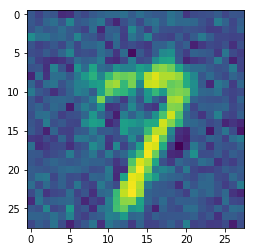

In [ ]:
for epoch in range(num_epochs):

    for i in range(len(images) // batch_size):
        
        #sample images
        batch_image = images[i * batch_size:(i + 1) * batch_size]
        
        #sample the condition that is, digit we want to generate
        batch_c = labels[i * batch_size:(i + 1) * batch_size]
        
        #sample noise
        batch_noise = np.random.normal(0, 1, (batch_size, 100))
        
        #train the generator
        generator_loss, _ = session.run([D_loss, D_optimizer], {x: batch_image, c: batch_c, z: batch_noise})
           
        #train the discriminator
        discriminator_loss, _ = session.run([G_loss, G_optimizer],  {x: batch_image, c: batch_c, z: batch_noise})
    
    #sample noise
    noise = np.random.rand(1,100)
    
    #select specific digit
    gen_label = np.array([[label_to_generate]]).reshape(-1)
    
    #convert the selected digit
    one_hot_targets = np.eye(num_classes)[gen_label]
    
    #Feed the noise and one hot encoded condition to the generator and generate the fake image
    _fake_x = session.run(fake_x, {z: noise, c: one_hot_targets})
    _fake_x = _fake_x.reshape(28,28)
    
   
    
    print("Epoch: {},Discriminator Loss:{}, Generator Loss: {}".format(epoch,discriminator_loss,generator_loss))
    
    #plot the generated image
    display.clear_output(wait=True)
    plt.imshow(_fake_x) 
    plt.show()

Thus, with CGAN we can generate a speific image that we want to generate. In the next section, we will learn about InfoGAN which is the unsupervised version of CGAN.